## Renting Listing Inquiries prediction
Data: Two Sigma Connect: Rental Listing Inquiries(2017 kaggle competetion)
Task: predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. 
<br>The target variable : interest_level.
<br>Solution: Logistic regression with L1 regularization
***
Features:
<br>bathrooms: number of bathrooms，
<br>bedrooms: number of bathrooms，
<br>building_id，
<br>created，
<br>description，
<br>display_address，
<br>features: a list of features about this apartment，
<br>latitude，
<br>listing_id，
<br>longitude，
<br>manager_id，
<br>photos: a list of photo links，
<br>price: in USD，
<br>street_address，
<br>interest_level: has 3 categories: 'high', 'medium', 'low'

In [1]:
# import necessary tools
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
# extract text feature to a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

from scipy import sparse

#encode the categorical feature
from sklearn.preprocessing import LabelEncoder

# cluster the address feature
from sklearn.cluster import KMeans
from nltk.metrics import distance as distance

#make plots
from matplotlib import pyplot
import seaborn as sns

%matplotlib inline

### Read & Discovery data

In [2]:
# read data
train = pd.read_json('../RentListingInquries_train.json')
test = pd.read_json('../RentListingInquries_test.json')

train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


In [5]:
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


Text(0,0.5,'Number of occurrences')

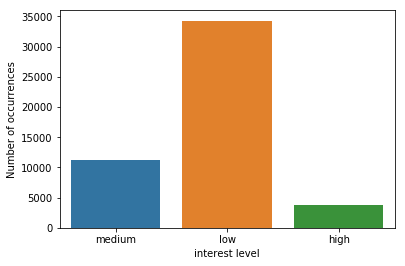

In [6]:
# Target distribution，check wether categories are fairly distributed
sns.countplot(train.interest_level)
pyplot.xlabel('interest level')
pyplot.ylabel('Number of occurrences')

### Feature Engineering
#### 1. encode interest level with number

In [7]:
y_map = {'low': 2, 'medium': 1, 'high': 0}
train['interest_level'] = train['interest_level'].apply(lambda x:y_map[x])
# remove id, as it has no effect on interest_level
y_train = train['interest_level']
train.drop(['listing_id', 'interest_level'], axis = 1, inplace = True)

test_id = test['listing_id']
test.drop(['listing_id'], axis = 1, inplace = True)

#### 2. price, bathrooms, bedrooms

In [8]:
def remove_noise(df):
    df = df[df.price < 10000]
    
    df.loc[df["bathrooms"] == 112, "bathrooms"] = 1.5
    df.loc[df["bathrooms"] == 10, "bathrooms"] = 1
    df.loc[df["bathrooms"] == 20, "bathrooms"] = 2

In [9]:
# create new feature: price per room
def create_price_room(df):
    df['price_bathrooms'] = (df["price"])/(df["bathrooms"] + 1.0)
    df['price_bedrooms'] = (df["price"])/(df["bedrooms"] +1.0)

In [10]:
# create new feature: sum and difference of rooms
def create_room_diff_sum(df):
    df["room_diff"] = df["bathrooms"] - df["bedrooms"]
    df["room_num"] = df["bedrooms"] + df["bathrooms"]

#### 3. create date

In [11]:
def procdess_created_date(df):
    df['Date'] = pd.to_datetime(df['created'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Wday'] = df['Date'].dt.dayofweek
    df['Yday'] = df['Date'].dt.dayofyear
    df['hour'] = df['Date'].dt.hour
    
    df.drop(['Date', 'created'], axis = 1, inplace = True)

#### 4. remove decription
For little use in this model, so remove it directly

In [12]:
def procdess_description(df):
    df.drop(['description'], axis = 1, inplace = True)

#### 5. manager_id
Divide the managers: top 1%, 2%, 5%, 10, 15, 20...

In [13]:
def procdess_manager_id(df):
    managers_count = df['manager_id'].value_counts()
    
    df['top_1_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 99)] else 0)
    df['top_2_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 98)] else 0)
    df['top_5_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 95)] else 0)
    df['top_10_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 90)] else 0)
    df['top_15_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 85)] else 0)
    df['top_20_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 80)] else 0)
    df['top_25_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 75)] else 0)
    df['top_30_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 70)] else 0)
    df['top_50_manager'] = df['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 50)] else 0)
    
    df.drop(['manager_id'], axis = 1, inplace = True)

#### 6. building_id

In [14]:
# remove building id
def procdess_building_id(df):
    df.drop(['building_id'], axis = 1, inplace = True)

#### 7. latitude & longtitude

In [15]:
def procdess_location_train(df):   
    train_location = df.loc[:,[ 'latitude', 'longitude']]
    
     # Clustering
    kmeans_cluster = KMeans(n_clusters=20)
    res = kmeans_cluster.fit(train_location)
    res = kmeans_cluster.predict(train_location)

    df['cenroid'] = res

    # L1 distance
    center = [ train_location['latitude'].mean(), train_location['longitude'].mean()]
    df['distance'] = abs(df['latitude'] - center[0]) + abs(df['longitude'] - center[1])
    
    #delete raw features
    df.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    return kmeans_cluster,center

In [16]:
def procdess_location_test(df, kmeans_cluster, center):   
    test_location = df.loc[:,[ 'latitude', 'longitude']]
    
     # Clustering
    res = kmeans_cluster.predict(test_location)

    df['cenroid'] = res

    # L1 distance
    df['distance'] = abs(df['latitude'] - center[0]) + abs(df['longitude'] - center[1])
    df.drop(['latitude', 'longitude'], axis=1, inplace=True)

#### 8. display_address

In [17]:
def procdess_display_address_train_test(df_train, y_train, df_test):
    n_train_samples = len(df_train.index)    
    df_train_test = pd.concat((df_train, df_test), axis=0)

    lb = LabelEncoder()
    lb.fit(list(df_train_test['display_address'].values))
    df_train_test ['display_address'] = lb.transform(list(df_train_test['display_address'].values))
    
    #import pdb
    #pdb.set_trace()
    me = MeanEncoder(['display_address'], target_type='classification')
    
    # has not encode test dataset as fit mainly on train dataset
    df_train_test = me.fit_transform(df_train_test, y_train)

    df_train_test.drop(['display_address'], axis=1,inplace = True)
    
    df_train = df_train_test.iloc[:n_train_samples, :]
    df_test = df_train_test.iloc[n_train_samples:, :]
    
    return df_train, df_test

In [18]:
def procdess_display_address(df):
    df.drop(['display_address'], axis=1,inplace = True)

#### 9. street address

In [19]:
# with the same information as display_address, so remove it
def procdess_street_address(df):
    df = df.drop(['street_address'], axis=1,inplace = True)

#### 10. features

In [20]:
def procdess_features_train_test(df_train, df_test):
    n_train_samples = len(df_train.index)
    
    df_train_test = pd.concat((df_train, df_test), axis=0)
    df_train_test['features2'] = df_train_test['features']
    df_train_test['features2'] = df_train_test['features2'].apply(lambda x: ' '.join(x))

    c_vect = CountVectorizer(stop_words='english', max_features=200, ngram_range=(1, 1), decode_error='ignore')
    c_vect_sparse = c_vect.fit_transform(df_train_test['features2'])
    c_vect_sparse_cols = c_vect.get_feature_names()

    df_train.drop(['features'], axis=1, inplace=True)
    df_test.drop(['features'], axis=1, inplace=True)
    
    # use hstack to combine all numerical feature with sparse
    df_train_sparse = sparse.hstack([df_train, c_vect_sparse[:n_train_samples,:]]).tocsr()
    df_test_sparse = sparse.hstack([df_test, c_vect_sparse[n_train_samples:,:]]).tocsr()
    
    # normal datafrmae
    tmp = pd.DataFrame(c_vect_sparse.toarray()[:n_train_samples,:],columns = c_vect_sparse_cols, index=df_train.index)
    df_train = pd.concat([df_train, tmp], axis=1)
    
    tmp = pd.DataFrame(c_vect_sparse.toarray()[n_train_samples:,:],columns = c_vect_sparse_cols, index=df_test.index)
    df_test = pd.concat([df_test, tmp], axis=1)
  
    return df_train_sparse,df_test_sparse,df_train, df_test

In [21]:
def procdess_features_test(df, c_vect):
    df['features2'] = df['features']
    df['features2'] = df['features2'].apply(lambda x: ' '.join(x))

    c_vect_sparse = c_vect.transform(df['features2'])
    c_vect_sparse_cols = c_vect.get_feature_names()

    df.drop(['features', 'features2'], axis=1, inplace=True)
    
    df_sparse = sparse.hstack([df, c_vect_sparse]).tocsr()
    
    tmp = pd.DataFrame(c_vect_sparse.toarray(),columns = c_vect_sparse_cols, index=df.index)
    df = pd.concat([df, tmp], axis=1)
    
    return df_sparse, df

#### 11. photos

In [22]:
def procdess_photos(df):
    df.drop(['photos'], axis = 1, inplace = True)

#### 12. feature engineering for train and test dataset

In [23]:
remove_noise(train)
create_price_room(train)
create_room_diff_sum(train)
procdess_created_date(train)
procdess_description(train)
procdess_manager_id(train)
procdess_building_id(train)
procdess_photos(train)
procdess_street_address(train)
procdess_display_address(train)

remove_noise(test)
create_price_room(test)
create_room_diff_sum(test)
procdess_created_date(test)
procdess_description(test)
procdess_manager_id(test)
procdess_building_id(test)
procdess_photos(test)
procdess_street_address(test)
procdess_display_address(test)

X_train_sparse,X_test_sparse,train,test = procdess_features_train_test(train,test)

/Users/hankaei/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
# save feature to csv file
#train = pd.concat([train, y_train], axis=1)
#test= pd.concat([test_id,test],axis = 1)
#train.to_csv('RentListingInquries_FE_train.csv', index=False)
#test.to_csv('RentListingInquries_FE_test.csv', index=False)

In [35]:
#normalize data
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

train = pd.read_csv('../RentListingInquries_FE_train.csv')
test = pd.read_csv('../RentListingInquries_FE_test.csv')

y_train = train['interest_level']
X_train = train.drop(['interest_level'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
#X_test = test

ss_X = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.fit_transform(X_test)

In [36]:
print (len(X_train), len(y_train), len(X_test), len(y_test))

800 800 200 200


### Train the model
#### default Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# cross validation
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv = 5, scoring = 'neg_log_loss')

print ('logloss of each fold is:', -loss)
print ('cv logloss is:', -loss.mean() )

logloss of each fold is: [ 0.94229968  0.98229176  0.96554445  0.95388658  0.81346911]
cv logloss is: 0.931498316731


#### Logistic regression model with regularization 

In [38]:
#use GridsearchCV to find the best regularization model and the roughly parameter
from sklearn.model_selection import GridSearchCV

penaltys = ['l1', 'l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty = LogisticRegression()
grid = GridSearchCV(lr_penalty, tuned_parameters, cv=5, scoring = 'neg_log_loss')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [39]:
grid.cv_results_

{'mean_fit_time': array([ 0.00559149,  0.01136675,  0.00539637,  0.02043777,  0.01580672,
         0.03791285,  0.16864195,  0.09052114,  0.74639444,  0.18285856,
         1.98039145,  0.28281422,  3.60673347,  0.30935354]),
 'mean_score_time': array([ 0.00119519,  0.00094233,  0.00210128,  0.00091181,  0.00101833,
         0.00091238,  0.00093856,  0.00092583,  0.00103483,  0.00093684,
         0.00095272,  0.0009356 ,  0.00095673,  0.00094471]),
 'mean_test_score': array([-1.09861229, -1.02975755, -0.91767707, -0.86578522, -0.72142575,
        -0.8251952 , -0.82936492, -0.93164487, -1.03294129, -1.07479257,
        -1.22717114, -1.22099356, -1.43578567, -1.35618046]),
 'mean_train_score': array([-1.09861229, -0.99769493, -0.91766914, -0.757497  , -0.66337993,
        -0.59105413, -0.55056375, -0.54336416, -0.53521558, -0.53502653,
        -0.5338306 , -0.5338379 , -0.53371951, -0.53371629]),
 'param_C': masked_array(data = [0.001 0.001 0.01 0.01 0.1 0.1 1 1 10 10 100 100 1000 1000],


In [40]:
#show best score and parameter
print(-grid.best_score_)
print(grid.best_params_)

0.721425752614
{'C': 0.1, 'penalty': 'l1'}


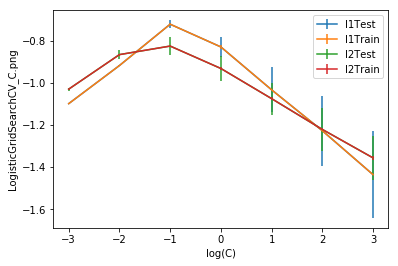

In [41]:
# plot CV
test_means = grid.cv_results_['mean_test_score']
test_stds = grid.cv_results_['std_test_score']
train_means = grid.cv_results_['mean_test_score']
train_stds = grid.cv_results_['std_train_score']

# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs, number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs, number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs, number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs, number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    pyplot.errorbar(x_axis, test_scores[:,i], yerr = test_stds[:,i], label = penaltys[i]+'Test')
    pyplot.errorbar(x_axis, train_scores[:,i], yerr = train_stds[:,i], label = penaltys[i]+'Train')
    
pyplot.legend()
pyplot.xlabel('log(C)')
pyplot.ylabel('neg_logloss')
pyplot.ylabel('LogisticGridSearchCV_C.png')

pyplot.show()

#### Logistic Regression + L1

In [42]:
from sklearn.linear_model import LogisticRegressionCV
Cs = [0.01, 0.1, 1, 10]
lrcv_L1 = LogisticRegressionCV(Cs=Cs, cv=5, scoring='neg_log_loss', penalty='l1', solver='liblinear', multi_class='ovr')
lrcv_L1.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [43]:
lrcv_L1.scores_

{0: array([[-0.34711641, -0.25272684, -0.29494163, -0.37449917],
        [-0.34132419, -0.22968058, -0.24729539, -0.30025167],
        [-0.34132419, -0.24378942, -0.28056665, -0.33530613],
        [-0.34153785, -0.23844153, -0.28374565, -0.33887638],
        [-0.34153785, -0.23145594, -0.23858338, -0.28600995]]),
 1: array([[-0.62017546, -0.52934716, -0.61556073, -0.73379581],
        [-0.62050257, -0.52833678, -0.59314453, -0.73726602],
        [-0.62050257, -0.55383261, -0.69073035, -0.95134104],
        [-0.61939087, -0.5198847 , -0.5935974 , -0.67308766],
        [-0.61939087, -0.50956123, -0.56321923, -0.67370982]]),
 2: array([[-0.67988321, -0.53999952, -0.61772515, -0.70091294],
        [-0.67974648, -0.53049302, -0.63865225, -0.84337646],
        [-0.67974648, -0.56379367, -0.67486761, -0.92704948],
        [-0.67991953, -0.53213378, -0.5961082 , -0.70862185],
        [-0.67991953, -0.51297073, -0.55526301, -0.67868114]])}

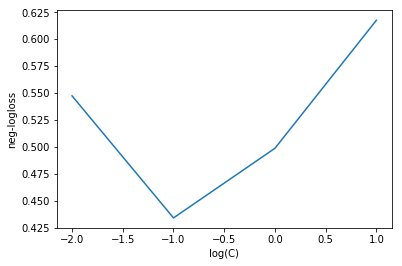

In [44]:
n_Cs = len(Cs)
n_classes = 3
scores = np.zeros((n_classes, n_Cs))

for j in range(n_classes):
    scores[j][:] = np.mean(lrcv_L1.scores_[j], axis = 0)

mse_mean = -np.mean(scores, axis = 0)
pyplot.plot(np.log10(Cs), mse_mean.reshape(n_Cs, 1))
pyplot.xlabel('log(C)')
pyplot.ylabel('neg-logloss')
pyplot.show()

In [45]:
lrcv_L1.coef_

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -3.29740275e-01,
         -2.90030642e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.04141978e-02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.83097249e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.28499640e-02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   6.90949357e-02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [46]:
#get prediction
pred = lrcv_L1.predict(X_test)